This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# GaPSE TUTORIAL

This is a small tour of the Galaxy Power Spectrum Estimator software. It shows
how the program can be easily used inside a Jupyter Notebook.

However, if you prefer, you can also write the commands you are interested to execute inside the file "GaPSE-exe.jl", and then run in the command line

```
$ julia GaPSE-exe.jl
```

Furthermore, almost all the functions implemented inside GaPSE have a detailed documentation; feel free to check it whenever you want with the usual Julia command `?NAME` (where `NAME` is the name of the function/object you are interested in).

For this tutorial we will show the computation of the Two-Point Correlation Functions (TPCFs) concerning the Luminosity Distance (LD) perturbations. The code may computes in a very intuitive way also the relativistic Galaxy Number Counts (GNC) one's and the cross correlations GNCxLD and LDxGNC.

## Path to GaPSE

First of all, we have to include GaPSE in our Jupyter Notebook:

In [1]:
# In case you prefer to use GaPSE in a Jupyter Notebook in a "distant" directory,
# you only have to set this path equal to the directory GaPSE is stored in.
PATH_TO_GAPSE = "../"; 

In [2]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");
# NOTE : do not run this cell multiple times! In you have a problem, restart
# the kernel an re-run all the cells.

In [3]:
using DelimitedFiles, Plots, Printf, LaTeXStrings 
# These are useful libraries for plots and reading files, but they are not
# mandatory in order to run the code

```




```

## Creation of a Cosmology 

The fundamental struct of GaPSE is `Cosmology`; it contains all the 
relevant information for future computations.

Let's have a look at the `Cosmology` constructor:

```julia
Cosmology(params::CosmoParams, file_data::String,
    file_ips::String, file_windowF::String,
    file_IntwindowF::String)
```


As we can see, in order to create such a struct, we must give a `params::CosmoParams` struct (we will see it later) and 4 input files:
- `file_data` : the background data for the Universe considered;
- `file_ips` : the matter power spectrum at redshift z=0 we are focused on;
- `file_windowF` : a map on μ and x of the window function F (use the default one initially, provided inside GaPSE directory `data/`);
- `file_IntwindowF` : a map on μ and s of the window function F integrated over `s_1` (again, use the default one initially, provided inside GaPSE directory `data/`);
  
The first two files should be produced by the [CLASS](https://github.com/lesgourg/class_public) software. As an example, we take the two stored inside `data/`:

In [9]:
FILE_PS = PATH_TO_GAPSE * "data/WideA_ZA_pk.dat";
FILE_BACKGROUND = PATH_TO_GAPSE * "data/WideA_ZA_background.dat";
FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt";
FILE_IF_MAP = PATH_TO_GAPSE * "data/IntegrF_REFERENCE_pi2.txt";

Now we have to set the dimensions of the survey we are considering. 

GaPSE assumes that the survey has an azimutally simmetric volume, contained inside two concentric spheres (with radius specified by the input minimum and maximum redshifts `z_min` and `z_max`) and with angular extensions `2 θ_max` (so `θ_max` is the angle between the central axis and the edge). The extreme redshifts are internally translated into extreme comoving distances $s_\mathrm{min}$ and $s_\mathrm{max}$.

Here we show a orthogonal projection on the plane containing the three points $O$ (the observer), $\mathbf{s}_\mathrm{min}$ and $\mathbf{s}_\mathrm{max}$.

<img src="images/survey.png" style="width: 400px;">

We also show the comoving effective distance $s_\mathrm{eff}$, which is the counterpart of the effective redshift $z_\mathrm{eff}$ calculated as follows:

$$
\begin{split}
z_\mathrm{eff} := 
    \frac{
        \int \mathrm{d}^3\mathbf{s} \, \phi^2(\mathbf{s}) \, z(s)
     }{
         \int \mathrm{d}^3\mathbf{s}\, \phi^2(\mathbf{s}) 
      } &= \frac{
          \int_0^\infty \mathrm{d}s  \, s^2 \, \phi^2(s) \, z(s) \times
          \int_{4\pi}\mathrm{d}^2\hat{\mathbf{s}} \, W^2(\hat{\mathbf{s}})
      }{
          \int_0^\infty \mathrm{d}s \, s^2 \, \phi^2(s)\times
          \int_{4\pi}\mathrm{d}^2\hat{\mathbf{s}} \, W^2(\hat{\mathbf{s}})
      } \\[5pt]
      &= \frac{
          \int_0^\infty \mathrm{d}s  \, s^2 \, \phi^2(s) \, z(s)
      }{
          \int_0^\infty \mathrm{d}s \, s^2 \, \phi^2(s)
      } \\[4pt]
      &= \frac{3}{s_\mathrm{max}^3 - s_\mathrm{min}^3} \,
          \int_{s_\mathrm{min}}^{s_\mathrm{max}} \mathrm{d}s  \, s^2 \, z(s)
\end{split}
$$

where $\phi(s)$ and $W(\hat{s})$ are respectivelly the radial and angulal window functions; it is assumed that the survey window function $\phi(\mathbf{s})$ can be separated into a radial and angular part:

$$
\phi(\mathbf{s}) = \phi(s) \, W(\hat{s})
$$

$$ \phi(s, s_\mathrm{min}, s_\mathrm{max}) = 
    \begin{cases} 1 \quad s_\mathrm{min} < s < s_\mathrm{max} \\ 0 \quad \mathrm{otherwise}\end{cases} $$
    
 $$ W(\hat{s}, \theta_\mathrm{MAX}) = 
    \begin{cases} 1 \quad 0 \leq \theta < \theta_\mathrm{MAX} \\ 0 \quad \mathrm{otherwise}\end{cases} $$

If you are not interested in a specific survey, but only in the "true" TPCFs of the Universe considered, do not worry: let the default values for these fields, in the functions we are going to show you will only have 
to set `use_window = false`.

For this demo case, let's set the following survey volume values:

In [6]:
z_min, z_max, θ_max = 0.05, 0.20, π / 2.0;

At this point, we have to create the `CosmoParams` struct previously mentioned, that will contains all the options to be passed to `Cosmology`.
Beyond the already mentioned `z_min`, `z_max` and `θ_max` (which are mandatory), you may choose to specify:
- `Ω_b::Float64` and `Ω_cdm::Float64` : barionic and cold-dark-matter density parameters

- `h_0::Float64` : today's Hubble adimensional parameter ($H_0 = h_0 \times 100 \; \mathrm{km}/(\mathrm{s}  \, \mathrm{Mpc})$).

- `b::Float64` : galaxy bias.

- `s_b::Float64` : magnification bias, i.e. the slope of the luminosity function at the luminosity threshold.

- `𝑓_evo::Float64` : evolution bias.

- many others; if you are interested, check the documentation of `CosmoParams`.

Here we provided the full list of them, with all their default values.

In [7]:
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = Dict(
        :llim => 0.0, :rlim => Inf, :N => 1000,
         :trap => true, :rtol => 1e-2, :atol => 0.0,
         :ss_start => 0.0, :ss_step => 10.0,
         :ss_stop => 0.0),
);

Finally, we can create the `Cosmology` (let's call it `cosmo`) with all the inputs specified before!
We also print on the screen all the options stored by that `Cosmology` itself, in order to be sure that everything is okay, through the function `parameters_used`.

In [10]:
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, 
    FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo);

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../data/WideA_ZA_pk.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Background data input file: "../data/WideA_ZA_background.dat"
#
# - Basic CosmoParams considered: 
#	 z_min = 0.05 	 z_max = 0.2
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 𝑓_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 10.0 	 N = 1000 	 rtol = 0.01 	 
#	 llim = 0.0 	 atol = 0.0 	 rlim = Inf 	 
#	 ss_stop = 0.0 	 trap = true 	 ss_s

Now we are ready to calculate the TPCF and/or PS associated with each of the GR effects for this Universe!

```




```

## TPCF of a single effect

The Genearal Relativistic (GR) effects affection LD are 4: Doppler, Lensing, Local GP and Integrated GP (where GP stands for Gravitational Potential).

Consequently, the TPCFs associated are $4\times4=16$ (4 are auto-correlations, and 12 the cross-ones; note that they are not simmetric, so for instance Lensing-Doppler is different from Doppler-Lensing).

Their names are, with obvious associations, the ones contained inside the
`GaPSE.GR_EFFECTS_LD` vector:

In [12]:
GaPSE.GR_EFFECTS_LD

16-element Vector{String}:
 "auto_doppler"
 "auto_lensing"
 "auto_localgp"
 "auto_integratedgp"
 "lensing_doppler"
 "doppler_lensing"
 "doppler_localgp"
 "localgp_doppler"
 "doppler_integratedgp"
 "integratedgp_doppler"
 "lensing_localgp"
 "localgp_lensing"
 "lensing_integratedgp"
 "integratedgp_lensing"
 "localgp_integratedgp"
 "integratedgp_localgp"

As a first example, we will focus on the Doppler auto-correlation function, identified by the name `auto_doppler`.

How we may calculate the value of such TPCF, for the considered Cosmology `cosmo`?
GaPSE provides three functions:

- `ξ_LD_multipole`
- `map_ξ_LD_multipole`
- `print_map_ξ_LD_multipole`

The frame of reference you have to keep in mind is the following:

<table><tr>
<td> <img src="images/s1s2.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="images/s1s2_inside_survey.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

GaPSE assumes (unless differently specified) that $\mathbf{s}_1$ is on the $s_\mathrm{eff}$ sphere (and so $s_1 = s_\mathrm{eff}$). The second input $s$ is the comoving distance from $s_1$, as you can see from the sketch.

These are the transformations concerning the two coordinate systems:

$$
y = \cos \theta = \hat{\mathbf{s}}_1 \cdot  \hat{\mathbf{s}}_2 
\quad , \quad
\mu = \cos \phi = \hat{\mathbf{s}}_1 \cdot  \hat{\mathbf{s}}
$$

$$
s(s_1, s_2, y) = \sqrt{s_1^2 + s_2^2 - 2 \, s_1 \, s_2 \, y}
\quad , \quad
s_2(s_1, s, \mu) = \sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}
$$

$$
\mu(s_1, s_2, y) = \frac{y \, s_2 - s_1}{s(s_1, s_2, y)}
\quad , \quad
y(s_1, s, \mu) = \frac{\mu \, s + s_1}{s_2(s_1, s, \mu)} 
$$

```


```

### ξ_LD_multipole

```julia
ξ_LD_multipole(s1, s, effect::String, 
    cosmo::Cosmology; 
    L::Integer = 0, use_windows::Bool = true,
    kwargs...) ::Float64
``` 

Returns the value of the chosen LD GR `effect` multipole (of order `L`) calculated in `s1` and a distance `s` from it, in the given Cosmology `cosmo`.

As previously explained, you have to set the flag `use_windows = false` if you are not interested in a specific survey, and `use_windows = true` (or not set the flag at all, since `true` is the default value) if you are.

Let's calculate the value of the `auto_doppler` effect CF in `s1 = s_eff` and `s = 50` (all the distances are measured in $h_0^{-1} \, \mathrm{Mpc}$), both with and without window function. You may try to change the `s` value to another one you prefer.

NOTE: GaPSE is conceived for computation on large scales; at the moment, the values for small comoving distance `s` (under few $h_0^{-1}\,\mathrm{Mpc}$) are not correct, especially for high order multipoles (`L=1,2,...`)

In [14]:
GaPSE.ξ_LD_multipole(cosmo.s_eff, 50, "auto_doppler", cosmo; 
    L = 0, use_windows = false)

1.2864097997132365e-5

In [16]:
GaPSE.ξ_LD_multipole(cosmo.s_eff, 50, "auto_doppler", cosmo; 
    L = 0, use_windows = true)

28257.649053122346

In [17]:
GaPSE.ξ_LD_multipole(cosmo.s_eff, 50, "auto_doppler", cosmo; 
    L = 0)

28257.649053122346

NOTE: it would appear natural, in the Julia language, to use the broadcast operator and/or comprehension lists in order to calculate the chosen GR `effect` multipole in `s1` (fixed) for a vector of `s` distances from it `v_ss`, in the given Cosmology `cosmo`. In other words, it may seem straightforward to write:

```julia
    v_ss = range(1, 1000, length = 100)
    res = [GaPSE.ξ_multipole(cosmo.s_eff, s, 
        "auto_doppler", cosmo; L = 0) 
        for s in v_ss]
```

Do not do it: due to the way the program is build, it is computationally faster
and more accurate to use other GaPSE functions (`map_ξ_multipole` and so on, which we will present in the next section).

And for the next multipoles? Simply set the keyword parameter `L` to the order you need.

In [18]:
vec = [GaPSE.ξ_LD_multipole(cosmo.s_eff, 50, 
        "auto_doppler", cosmo; L = L, use_windows = false) 
        for L in 0:4]
for (i, r) in enumerate(vec)
    println("L = $(i-1) :  xi^{Doppler} = $r")
end

L = 0 :  xi^{Doppler} = 1.2864097997132365e-5
L = 1 :  xi^{Doppler} = -1.7586640827874939e-6
L = 2 :  xi^{Doppler} = -7.699207418897386e-6
L = 3 :  xi^{Doppler} = 1.1115066425503669e-6
L = 4 :  xi^{Doppler} = -1.4686580852665365e-7


```

```

### map_ξ_LD_multipole

```julia
map_ξ_LD_multipole(cosmo::Cosmology, effect::String,
    v_ss::Union{Vector{Float64},Nothing} = nothing; 
    s1 = nothing, L::Integer = 0, 
    use_windows::Bool = true, kwargs... 
    ) ::Tuple{Vector{Float64}, Vector{Float64}}
```

For an input vector of distances `v_ss`, return a tuple with
- `v_ss` itself as first element
- the vector of values of the chosen GR `effect` multipole (of order `L`) calculated in `s1` for all the distances `s` contained in the vector `v_ss` (in the given Cosmology `cosmo`) as second element

If, as by default, `v_ss = nothing`, it is interally set `v_ss = 10 .^ range(-1, 3, length=N_log)`, where `N_log` is a keyword argument; this is why it is returned `v_ss`.

Likewise, if `s1 = nothing` (as by default), it is internally set `s1 = cosmo.s_eff`.

For instance, we might calculate the `auto_doppler` effect monopole CF in a linearly spaced set of points `range(1, 1000, length=300)`, both with and without window functions:

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:02



time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.06115 


time needed for map_ξ_LD_multipole for auto_doppler [in s] = 2.75232 



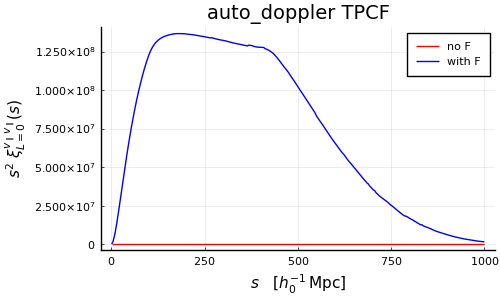

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/matteofoglieni/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [22]:
XS = range(1, 1000, length = 300)
xs1, ys1 = GaPSE.map_ξ_LD_multipole(cosmo, "auto_doppler", XS; 
    L = 0, use_windows = false);
xs2, ys2 = GaPSE.map_ξ_LD_multipole(cosmo, "auto_doppler", XS; 
     L = 0, use_windows = true);


pyplot()
plot(xs1, ys1 .* xs1 .^2,
    #xaxis=:log, #yaxis=:log, 
    lc=:red, ls=:solid, size=(500, 300),
    title="auto_doppler TPCF", label = "no F",
    ylabel=L"s^2 \; \xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)",
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    legend = :topright,
)
plot!(xs2, ys2 .* xs2 .^2,
    #xaxis=:log, #yaxis=:log, 
    lc=:blue, ls=:solid, size=(500, 300), label = "with F",
    ylabel=L"s^2 \; \xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)",
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
)

What if instead we are not interested in a survey and so the default `s1 = s_eff` is useless? Simply we set `s1` to the value we are interested in! Supposing `s1 = 400`, let's compare this one with the previous one without windows: 

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00



time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.15911 


time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.58955 



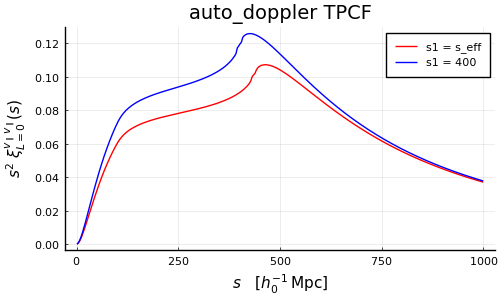

In [23]:
XS = range(1, 1000, length = 300)
xs1, ys1 = GaPSE.map_ξ_LD_multipole(cosmo, "auto_doppler", XS; 
    L = 0, use_windows = false)
xs2, ys2 = GaPSE.map_ξ_LD_multipole(cosmo, "auto_doppler", XS; 
    s1 = 400, L = 0, use_windows = false)


pyplot()
plot(xs1, ys1 .* xs1 .^2,
    #xaxis=:log, #yaxis=:log, 
    lc=:red, ls=:solid, size=(500, 300),
    title="auto_doppler TPCF", label = "s1 = s_eff",
    ylabel=L"s^2 \; \xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)",
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    legend = :topright,
)
plot!(xs2, ys2 .* xs2 .^2,
    #xaxis=:log, #yaxis=:log, 
    lc=:blue, ls=:solid, size=(500, 300), label = "s1 = 400",
    ylabel=L"s^2 \; \xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)",
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
)

```



```

### print_map_ξ_LD_multipole

```julia
print_map_ξ_LD_multipole(cosmo::Cosmology, out::String, 
    effect::Union{String,Function}, v_ss = nothing;
    s1 = nothing, kwargs...)
```

Same as `map_ξ_LD_multipole`, but the two resulting vectors are printed in the file `out`, together with all the options used for their computations.

For instance, let's print on a file named `my_first_doppler.txt` the `auto_doppler`TPCF monopole, calculated in the vector of values `ss = 10 .^ range(0, 3, length = 1000)`.

In [24]:
GaPSE.print_map_ξ_LD_multipole(cosmo, "my_first_doppler.txt", 
    "auto_doppler", 10 .^ range(0, 3, length = 1000); 
    L = 0, use_windows = false);

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00



time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.11974 



Here we plot the result:

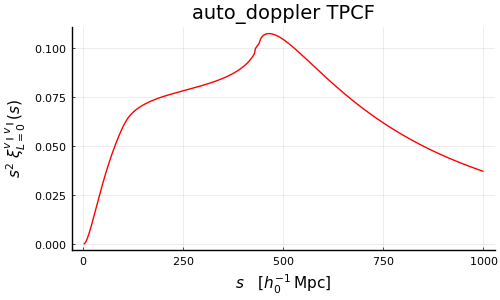

In [25]:
table = readdlm("my_first_doppler.txt", comments=true)
xs = convert(Vector{Float64}, table[:,1])
ys = convert(Vector{Float64}, table[:,2])

pyplot()
plot(xs, ys .* xs .^2,
    #xaxis=:log, #yaxis=:log, 
    lc=:red, ls=:solid,size=(500, 300),
    title="auto_doppler TPCF",
    ylabel=L"s^2 \; \xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)",
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    legend=false,
)

```


```

## TPCF of all the effects

The most straightforward path to calculate all the CFs (and also their sum) is through the three following functions:

- `sum_ξ_LD_multipole`
- `map_sum_ξ_LD_multipole`
- `print_map_sum_ξ_LD_multipole`

They work in the exactly same way of their corresponding "single-effect" one. The only difference is that the output is now not a single GR effect, but all of them plus their sum.

```

```

### sum_ξ_LD_multipole

```julia 
sum_ξ_LD_multipole(s1, s, cosmo::Cosmology; 
    L::Integer = 0, kwargs...
    )::Tuple{Float64,Vector{Float64}}
```
For input distances `s1` ans `s` and in the given Cosmology `cosmo`, returns a tuple which has:
- the sum of all the 16 LD TPCFs multipoles (of order `L`) calculated in `s1` and a distance `s` from it, in the given Cosmology `cosmo`.
- a vector of `Float64` values containing each off the 16 TPCF terms; they are ordered following the `GaPSE.GR_EFFECTS_LD` one

In [26]:
s = 1000
res_sum, res_xis = GaPSE.sum_ξ_LD_multipole(cosmo.s_eff, s, 
    cosmo; use_windows = false, L = 0);
res_sum, res_xis

(-2.0930732477010887e-8, [3.704291861268092e-8, 1.1467502280943454e-9, -8.701923462380552e-9, -1.3189924137843244e-9, 2.43701647048061e-10, -2.1595220348225198e-9, -5.172174721542147e-9, -2.0489890691159067e-8, -1.0752716680758877e-8, -4.856410325763263e-9, -5.03109072545446e-11, 1.9502603123228226e-9, 1.4893997289151214e-10, 3.645952372013118e-10, -6.476931321517375e-9, -1.8490259282671853e-9])

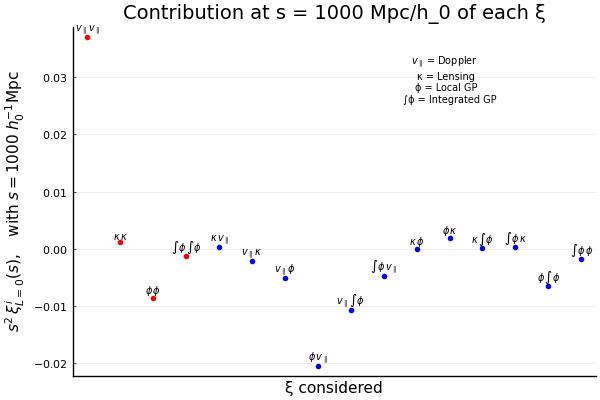

In [27]:
names = [
    L"v_{\parallel} \, v_{\parallel}", L"\kappa \, \kappa", 
    L"\phi \, \phi", L"\int\phi \, \int\phi", 
    
    L"\kappa \, v_{\parallel}", L"v_{\parallel} \, \kappa",
    L"v_{\parallel} \, \phi", L"\phi \, v_{\parallel}",
    L"v_{\parallel} \, \int\phi", L"\int\phi \, v_{\parallel}",
    L"\kappa \, \phi", L"\phi \, \kappa",
    L"\kappa \, \int\phi", L"\int\phi \, \kappa",
    L"\phi \, \int\phi", L"\int\phi \, \phi"
];
leg = L"v_{\parallel}"*" = Doppler    \n" *
        "κ = Lensing  \n"*"ϕ = Local GP  \n"*"∫ϕ = Integrated GP"

pyplot()
ys = [res_xis[i] for i in 1:length(res_xis)];
plot(1:16, ys .* (s^2), seriestype=:scatter, 
    series_annotations = [text(name; pointsize=7, valign=:bottom) 
        for name in names], 
    mc=vcat([:red for i in 1:4], [:blue for i in 5:16]), 
    markerstrokewidth = 0, legend=false,
    xlabel = "ξ considered",  xticks=false,
    ylabel = L"s^2 \, \xi^{i}_{L=0}(s)," * 
    L" \quad \mathrm{with} \; s = %$s \; h_0^{-1}\mathrm{Mpc}",
    
    title = "Contribution at s = $s Mpc/h_0 of each ξ"
    
)

annotate!([(12, 0.8*max(ys.* (s^2)...), text(leg; pointsize=7))])

```


```

### map_sum_ξ_LD_multipole

```julia
map_sum_ξ_LD_multipole(cosmo::Cosmology, 
    v_ss = nothing; L::Integer = 0, s1 = nothing, 
    kwargs...
    )::Tuple{Vector{Float64}, Vector{Float64},
        Vector{Vector{Float64}}}
```

As for `map_ξ_multipole`, returns also the vector `v_ss`. It's now prettly useless to spend more words on this instead of simply see it in action, isn't it?

In [28]:
ss, res_sums, res_xis = GaPSE.map_sum_ξ_LD_multipole(cosmo, 
    10 .^ range(0, 3, length = 100), use_windows = false);

auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:01:59
auto_localgp, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:09
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:02
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:01
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:01
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:13
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:15
localgp_integratedgp, L=0: 100%|████████████████████████| Time: 

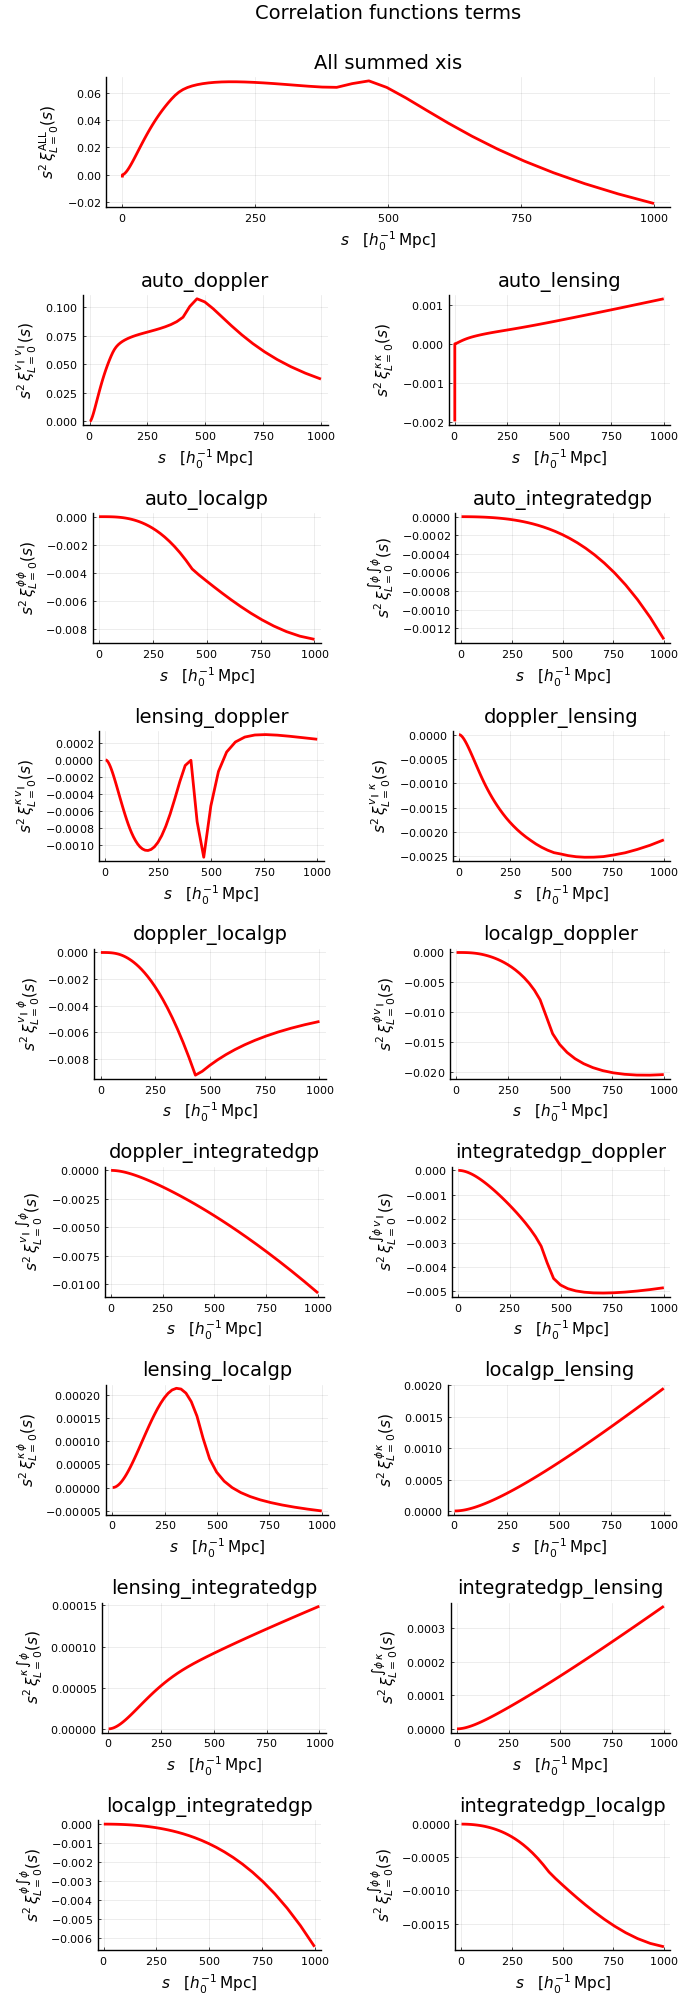

In [29]:
pyplot()
ps = [plot() for i in 1:length(GaPSE.GR_EFFECTS_LD) + 1]

title = plot(title = "Correlation functions terms", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos=[
    :bottomleft,
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]



ξs_names = [
    L"$\xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)$", 
    L"$\xi^{\kappa \, \kappa}_{L=0}(s)$", 
    L"$\xi^{\phi \, \phi}_{L=0}(s)$", 
    L"$\xi^{\int\phi \, \int\phi}_{L=0}(s)$", 
    
    L"$\xi^{\kappa \, v_{\parallel}}_{L=0}(s)$",
    L"$\xi^{v_{\parallel} \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{v_{\parallel} \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, v_{\parallel}}_{L=0}(s)$",
    
    L"$\xi^{v_{\parallel} \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, v_{\parallel}}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{\phi \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \phi}_{L=0}(s)$",
]

xs = ss

ps[1] = plot(xs, res_sums .* xs .^2, size=(300, 100),
        lw=2, lc="red", ls=:solid,
        title="All summed xis", 
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, \xi^{\mathrm{ALL}}_{L=0}(s)",
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px, legend=false)

for i in 1:length(GaPSE.GR_EFFECTS_LD)
    ys = res_xis[i]

    ps[i+1] = plot(
        xs, ys .* xs .^2, 
        size=(300, 100),
        lw=2, lc="red", ls=:solid,
        title=GaPSE.GR_EFFECTS_LD[i], 
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, " * ξs_names[i],
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px,
        legend = false,
    )
end

l = @layout [A{0.05h}; B ; a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
P = plot(title, ps..., layout=l, 
    left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(700,2000))

```



```

### print_map_sum_ξ_LD_multipole

```julia 
print_map_sum_ξ_LD_multipole(cosmo::Cosmology, 
    out::String, v_ss = nothing; s1 = nothing,
    L::Integer = 0, single::Bool = true, 
    kwargs...)
```
As `print_map_ξ_LD_multipole`, prints the output in the file `out`.

The only new thing to point out is the bool `single`: if `true`, all the CFs are printed inside the file of the sum, in a table with 18 columns (first one for `v_ss`, second for their sum an the next 16 for each effect). 

Otherwise, a new directory "all_standalones_CFs" is created (in the same path given in `out`) and they are separately saved in files there placed.

In [30]:
GaPSE.print_map_sum_ξ_LD_multipole(cosmo, 
    "my_first_all_xis.txt", 10 .^ range(0, 3, length = 100);
    L = 0, use_windows = false);

auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:02:00
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:09
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:01
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:11
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:12
localgp_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_localgp, L=0: 100%|████████████████████████| Time: 0:00:00



time needed for map_sum_ξ_LD_multipole [in s] = 157.00237 



In [31]:
table = readdlm("my_first_all_xis.txt", comments = true);
ss = convert(Vector{Float64}, table[:, 1]);
res_sums = convert(Vector{Float64}, table[:, 2]);
res_xis = [convert(Vector{Float64}, table[:, i]) for i in 3:18];

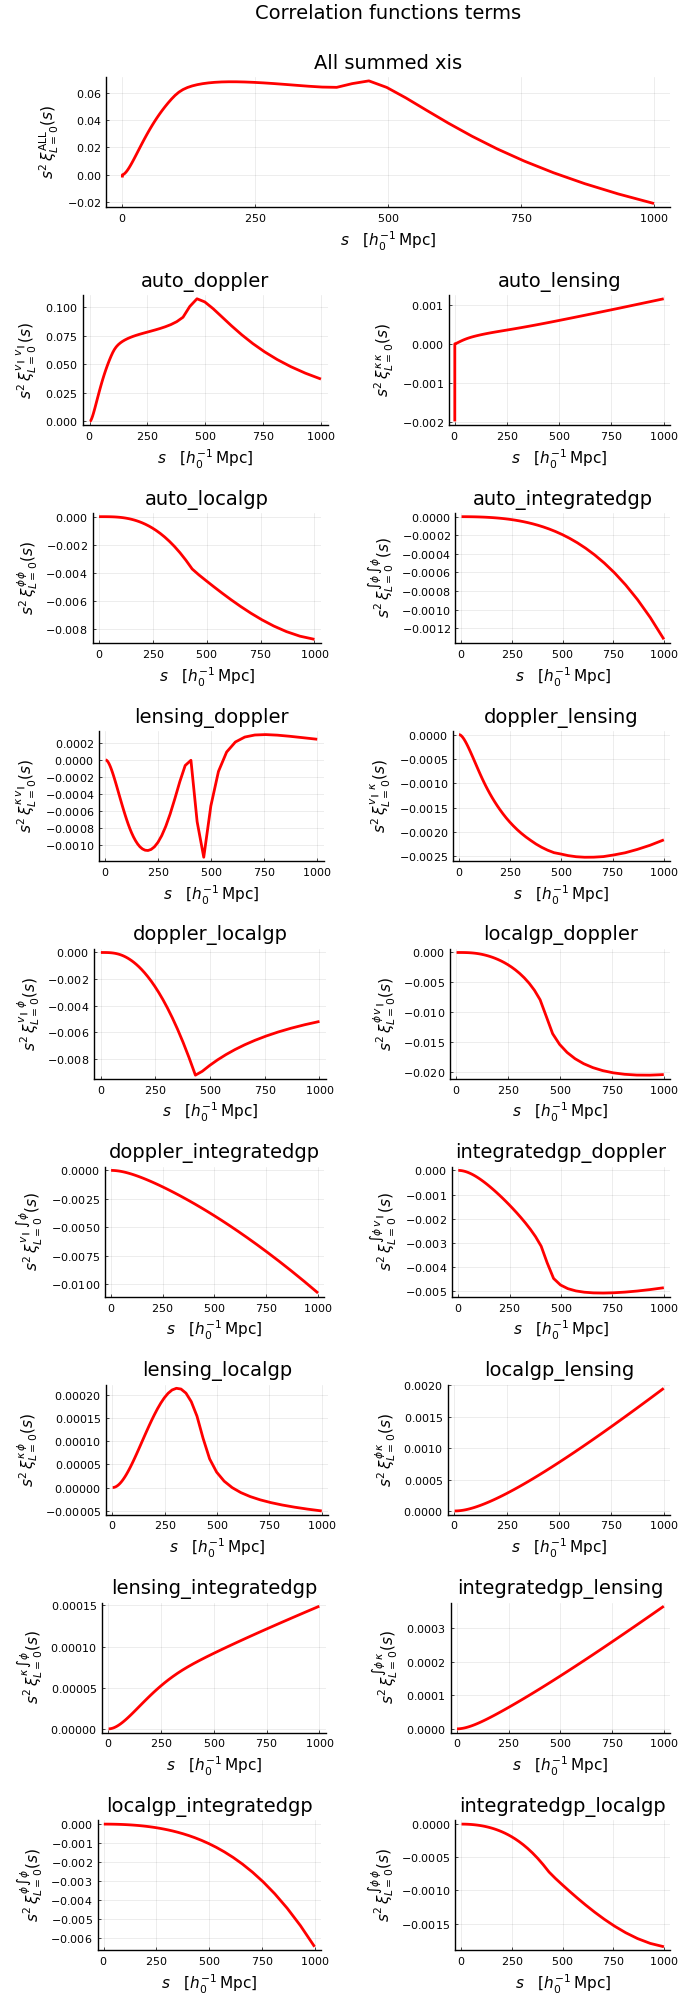

In [32]:
pyplot()
ps = [plot() for i in 1:length(GaPSE.GR_EFFECTS_LD) + 1]

title = plot(title = "Correlation functions terms", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos=[
    :bottomleft,
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]



ξs_names = [
    L"$\xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)$", 
    L"$\xi^{\kappa \, \kappa}_{L=0}(s)$", 
    L"$\xi^{\phi \, \phi}_{L=0}(s)$", 
    L"$\xi^{\int\phi \, \int\phi}_{L=0}(s)$", 
    
    L"$\xi^{\kappa \, v_{\parallel}}_{L=0}(s)$",
    L"$\xi^{v_{\parallel} \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{v_{\parallel} \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, v_{\parallel}}_{L=0}(s)$",
    
    L"$\xi^{v_{\parallel} \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, v_{\parallel}}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{\phi \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \phi}_{L=0}(s)$",
]

xs = ss

ps[1] = plot(xs, res_sums .* xs .^2, size=(300, 100),
        lw=2, lc="red", ls=:solid,
        title="All summed xis", 
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, \xi^{\mathrm{ALL}}_{L=0}(s)",
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px, legend=false)

for i in 1:length(GaPSE.GR_EFFECTS_LD)
    ys = res_xis[i]

    ps[i+1] = plot(
        xs, ys .* xs .^2, 
        size=(300, 100),
        lw=2, lc="red", ls=:solid,
        title=GaPSE.GR_EFFECTS_LD[i], 
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, " * ξs_names[i],
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px,
        legend = false,
    )
end

l = @layout [A{0.05h}; B ; a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
P = plot(title, ps..., layout=l, 
    left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(700,2000))

```





```

## Power Spectrum Multipole

Last but not least, from a CF file generated as previously showed, we can easily obtain the corresponding Power Spectrum multipole.
GaPSE provieds two functions:
- `PS_multipole`
- `print_PS_multipole`

```julia
PS_multipole(input::String; L::Integer = 0,
    int_s_min = 1e-3, int_s_max=1e3, 
    kwargs...) ::Tuple{Vector{Float64}, Vector{Float64}}
```

Return a tuple (`ks`, `pks`) of the Power Spectrum obtained from the CF stored in the file `input`, through the following expression: 

$$
P_L(k) = \frac{(-i)^L}{A^{'}} \, \phi(s_\mathrm{eff}) \int_0^\infty 
        \mathrm{d} s \; s^2 \, j_L(ks) \, \xi_L(s) \; ,
        \quad \; A^{'} = \frac{1}{4\,\pi}
$$

Computationally, the integration is made only for `int_s_min < s < int_s_max`.
Do not worry if the input TPCF is not defined in all the integration range: it will be fitted with two power laws at its extremes.

```julia
print_PS_multipole(input::String, out::String; L::Integer = 0, 
    int_s_min = 1e-3, int_s_max = 1e3, 
    kwargs...) ::Tuple{Vector{Float64}, Vector{Float64}}
```

Same as before, but store the results in a file named `out`.

NOTE: the multipole order `L` must be the same of the input TPCF in exam! Otherwise, the results would have no sense at all!

In [24]:
GaPSE.print_PS_multipole("my_first_doppler.txt",
    "my_first_ps_doppler.txt";
     L = 0, N = 1024, int_s_min=1e-3, int_s_max=1e3)


I'm computiong the PS_multipole from the file my_first_doppler.txt

time needed for Power Spectrum  computation [in s] = 0.20949292182922363


time needed for Power Spectrum  computation [in s] = 0.26917219161987305



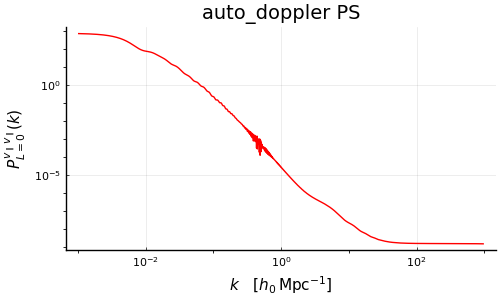

In [25]:
table = readdlm("my_first_ps_doppler.txt", comments=true)
xs = convert(Vector{Float64}, table[:,1])
ys = convert(Vector{Float64}, table[:,2])

pyplot()
plot(xs, ys,
    xaxis=:log, yaxis=:log, 
    lc=:red, ls=:solid,size=(500, 300),
    title="auto_doppler PS",
    ylabel=L"P^{v_{\parallel} \, v_{\parallel}}_{L=0}(k)",
    xlabel=L"k \quad [h_0\,\mathrm{Mpc}^{-1}]",
    legend=false,
)

```


```

## Window Function F

The bool `use_windows`'s work may be written as follows, with `U = use_windows`:

$$
\xi_L(s_1, s, \mu) = \frac{2 L + 1}{2} \int_{-1}^{+1} \mathrm{d}\mu \; 
    \xi (s_1, s, \mu) \, \mathcal{L}_L(\mu) \,\times
\begin{cases}  
     \mathcal{F(s, \mu)}\;,
        \quad \mathrm{U = true}\\
    1\;, \quad \mathrm{U = false}
\end{cases}
$$

$$
\mathcal{F}(s, \mu) = 
    \int_0^\infty \mathrm{d}s_1 \, \phi(s_1) \,  
    \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right) 
    \, F\left(\frac{s}{s_1}, \mu \right)
$$

with $F$ defined as follows (check the article of Emanuele Castorina and Enea Di Dio for more details):

$$
\begin{split}
F(x,\mu; \theta_\mathrm{max}) = & \;4\pi 
    \int_0^{\theta_\mathrm{max}} \mathrm{d}\theta_1 \int_0^\pi \mathrm{d} \theta \; 
    \, \Theta\left(\frac
        {x \cos \theta + \cos \theta_1}{\sqrt{x^1+2+2x\mu}} - 
        \cos(\theta_\mathrm{max}) 
        \right) 
    \, \Theta(\mu-\cos(\theta+\theta_1)) \\
    &\Theta(\cos(\theta - \theta_1)-\mu) \;
    \frac{\sin\theta\sin\theta_1}
        {\sqrt{(\sin\theta\sin\theta_1)^2-(\cos\theta\cos\theta_1-\mu)^2}}
\end{split}
$$

where the $\Theta$s are Heaviside theta functions.

The most efficient way to use $F$ in our computation is to calculate it separetely for a map of $\mu$ and $x$ values (with the $\theta_\mathrm{MAX}$ of the survey), then compute from it $\mathcal{F}$ and load them into the `Cosmology` we want to create. Internally, the code creates a 2d-spline from the input file of $F$.

In order to create suh a file, GaPSE provides the function `F_map`, which has two methods:

```julia
print_F_map(out::String,
    x_step::Float64 = 0.01, μ_step::Float64 = 0.01;
    x1 = 0, x2 = 3, μ1 = -1, μ2 = 1, 
    trap::Bool = true,
    Fmap_opts::Dict = Dict{Symbol,Any}(), 
    kwargs...)

print_F_map(out::String,
    xs::Vector{Float64}, μs::Vector{Float64};
    trap::Bool = true,
    Fmap_opts::Dict = Dict{Symbol,Any}(),
    kwargs...)
```

The first one creates a map of:
- $\mu$ values from `μ1 = -1` to `μ2 = 1` with linear step `μ_step`
- $x$ values from `x1 = 0` to `x2 = 3` with linear step `x_step`
and calculate $F$ in each point of this grid, saving the results in the file `out`.

The second one creates a grid from the input vector of $\mu$ and $x$ values, 
calculate $F$ in each point of this grid and save the results in the file `out`.

We now give here an example of use, which corresponds to the code necessary to produce the file `data/F_REFERENCE_pi2.txt`; consider that this computation, for the following values, might takes about 12 minutes. 

In [34]:
#=
reference_output =  "data/F_REFERENCE.pi2.txt"

xs = [x for x in 0:0.05:3]
μs = union([μ for μ in range(-1.0, -0.9, length = 50)], 
    [μ for μ in range(-0.9, 0.9, length = 50)],
    [μ for μ in range(0.9, 1.0, length = 50)])
GaPSE.print_F_map(PATH_TO_GAPSE * reference_output, 
    xs, μs; 
    trap = true
    Fmap_opts = Dict(
         :θ_max => π / 2.0, :tolerance => 1e-8, 
         :N => 1000, :pr => true
    )
)
=#

From such a file we can compute the integrated windof function $\mathcal{F}$, with one of the following methods:

```julia
print_map_IntegratedF(input::String, out::String, 
    z_min, z_max, μs::Vector{Float64}, 
    file_data::String; kwargs...)
print_map_IntegratedF(input::String, out::String, 
    s_min, s_max, μs::Vector{Float64}; kwargs...)

```

In the former you should specify the minimun and maxixum redshift of the survey you are interested in, and the `file_data` containing the background data needed to convert such redshift in comoving distances. In the latter, you should pass the comoving distances directly.

We now give here an example of use, which corresponds to the code necessary to produce the file `data/IntF_REFERENCE_pi2.txt`; consider that this computation, for the following values, might takes about 3 minutes. 

In [35]:
#=
calc_μs = union([μ for μ in range(-1.0, -0.9, length = 50)], 
    [μ for μ in range(-0.9, 0.9, length = 50)],
    [μ for μ in range(0.9, 1.0, length = 50)])

GaPSE.print_map_IntegratedF(
    PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt", 
    PATH_TO_GAPSE * "data/IntF_REFERENCE_pi2.txt", 
    0.05, 0.20, calc_μs, FILE_BACKGROUND;
    trap = true, 
    Dict(
        :ss_start => 100, :ss_stop => 500, 
        :ss_step => 50, :llim => 0.0, :rlim => Inf, 
        :rtol => 5e-2, :atol => 0.0, :N => 300, :pr => true,
    )...
)
=#